In [1]:
import numpy as np
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from factor_analyzer import factor_analyzer, FactorAnalyzer
from sklearn.decomposition import PCA
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset, TensorDataset
import import_ipynb
import SplitData as SD
#import BiLSTM as LSTM

importing Jupyter notebook from SplitData.ipynb


# Load Data

In [2]:
inputs = {}
for file_name in os.listdir('./New_Data/'):
    if file_name.startswith('.'):
        continue
    name = file_name.replace('.csv', '')
    path = './New_Data/' + file_name
    inputs[name] = pd.read_csv(path, index_col = 0)

## Processing Data

In [3]:
SD.splitActivities(inputs)
SD.splitAudio(inputs)
SD.splitDark(inputs)
SD.splitConversation(inputs)

### Load Processed Data

In [4]:
inputs = {}
for file_name in os.listdir('./Final_Data/'):
    if file_name.startswith('.'):
        continue
    name = file_name.replace('.csv', '')
    path = './Final_Data/' + file_name
    inputs[name] = pd.read_csv(path, index_col = 0)

### Split into positive negative and flourishing score dataframes

In [ ]:
flourishing = pd.read_csv('./StudentLife_Dataset/Outputs/FlourishingScale.csv')
panas = pd.read_csv('./StudentLife_Dataset/Outputs/panas.csv')
positive_score=['uid', 'Interested', 'Strong', 'Enthusiastic', 'Proud', 'Alert', 'Inspired', 'Determined ', 'Attentive', 'Active ']
negative_score=['uid', 'Distressed', 'Upset', 'Guilty', 'Scared', 'Hostile ', 'Irritable','Nervous', 'Jittery', 'Afraid ']
df_flour_post = pd.DataFrame()
df_pos_post = pd.DataFrame()
df_neg_post = pd.DataFrame()
   
for i in range(60):
    temp_flour_post = (flourishing.loc[flourishing['uid'] == 'u' + str(f"{i:02d}")].loc[flourishing['type'] == 'post']).drop(columns='type')
    df_flour_post = pd.concat([df_flour_post, temp_flour_post], axis = 0)
    
    temp_post = panas.loc[panas['uid'] == 'u' + str(f"{i:02d}")].loc[panas['type'] == 'post']
    df1_post = temp_post[positive_score]
    df2_post = temp_post[negative_score]
    df_pos_post = pd.concat([df_pos_post, df1_post], axis=0)
    df_neg_post = pd.concat([df_neg_post, df2_post], axis=0)
df_flour_post = df_flour_post.set_index(keys='uid')
df_pos_post = df_pos_post.set_index(keys='uid')
df_neg_post = df_neg_post.set_index(keys = 'uid')

# Factor Analysis

### Factor Analysis on flourishing score ###

eigen value: [4.72966388 0.98291258 0.77622504 0.64529042 0.33397926 0.24749074
 0.20296179 0.08147629]
[[0.31688052 0.21432535 0.19923823 0.66261105]
 [0.2585026  0.93824972 0.2168432  0.11459462]
 [0.07473832 0.2211992  0.71782709 0.53531789]
 [0.20701157 0.68741963 0.19542953 0.26829092]
 [0.59399358 0.10935955 0.45331901 0.27049275]
 [0.7777158  0.52599042 0.12197477 0.08841656]
 [0.75956878 0.24233212 0.22033764 0.38302414]
 [0.42648854 0.31416609 0.70535661 0.06603291]]


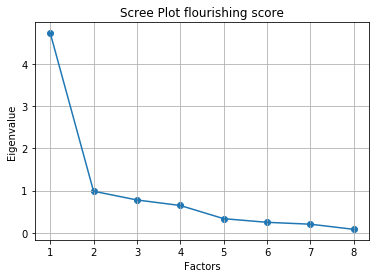

In [103]:
fa = FactorAnalyzer(rotation='varimax', n_factors = 4)
fa.fit(df_flour_post)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print('eigen value:',ev)
print(fa.loadings_)
fa.get_factor_variance()
fa.get_communalities()
#df_flour.corr()
plt.scatter(range(1,df_flour_post.shape[1]+1),ev)
plt.plot(range(1,df_flour_post.shape[1]+1),ev)
plt.title('Scree Plot flourishing score')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### Factor Analysis on positive score ###

[[ 0.31252945  0.48809547  0.34318804  0.14333055  0.3186381 ]
 [ 0.17112945  0.11043731  0.14584126  0.17266139  0.80293945]
 [ 0.85640211  0.15767178  0.32372807  0.09819369  0.02866413]
 [ 0.72819979  0.19321235  0.15843267  0.1288226   0.32075587]
 [ 0.09110964  0.69981486  0.0358399   0.1035544   0.05532749]
 [ 0.3252029   0.14043042  0.91288834  0.10540795  0.19090281]
 [ 0.54853043  0.505631    0.09944465 -0.07066513  0.37399943]
 [ 0.32331341  0.4281418   0.28070311  0.24085565  0.04220445]
 [ 0.1021346   0.170027    0.10395927  0.95768117  0.17593104]]


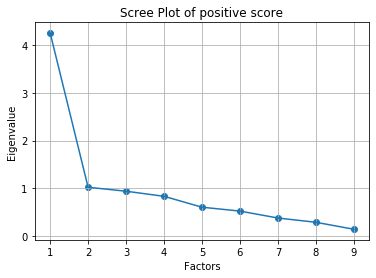

In [105]:
fa = FactorAnalyzer(rotation='varimax', n_factors = 5)
fa.fit(df_pos_post)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

print(fa.loadings_)
fa.get_factor_variance()
df_pos_post.corr()
plt.scatter(range(1,df_pos_post.shape[1]+1),ev)
plt.plot(range(1,df_pos_post.shape[1]+1),ev)
plt.title('Scree Plot of positive score')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### Factor Analysis on negative score ###

[[ 0.37626204  0.01805423  0.61551903  0.11402431  0.12347411]
 [ 0.23894706  0.23231523  0.9362824  -0.02442456  0.09137572]
 [-0.00779734  0.21617853  0.03522102  0.62532704 -0.01238882]
 [ 0.17711167  0.90800036  0.09656557  0.30352627  0.20372337]
 [ 0.5964478   0.1717456   0.24326655  0.02876155  0.22868964]
 [ 0.96297948  0.10067493  0.20400468  0.13991971  0.0806794 ]
 [ 0.4930571   0.36090192  0.30398745 -0.05111242  0.63124702]
 [ 0.6511574   0.19583206  0.25150032 -0.1864071   0.06473958]
 [ 0.1885959   0.87789882  0.15735423  0.13140605  0.04686113]]


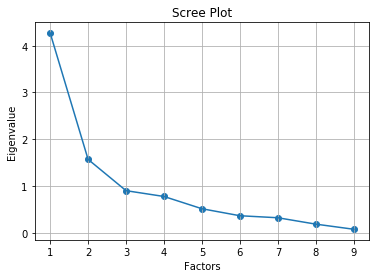

In [10]:
fa = FactorAnalyzer(rotation='varimax', n_factors = 5)
fa.fit(df_neg_post)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

print(fa.loadings_)
fa.get_factor_variance()
df_neg_post.corr()
plt.scatter(range(1,df_neg_post.shape[1]+1),ev)
plt.plot(range(1,df_neg_post.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### INPUT DATA for Flourishing Data###

In [12]:
## Look for people quit for post flourishing score testing ##
full_ids = []
for i in range(60):
    full_ids.append('u' + str(f"{i:02d}"))
ids_flour_post = df_flour_post.index.to_numpy()
quit_ids = list(set(full_ids) - set(ids_flour_post))
print(quit_ids)

['u18', 'u13', 'u22', 'u55', 'u12', 'u54', 'u41', 'u21', 'u26', 'u37', 'u38', 'u06', 'u11', 'u29', 'u40', 'u39', 'u57', 'u08', 'u50', 'u48', 'u58', 'u28', 'u25']


In [13]:
### Delete people quit, from dataframe ###
input_keys = inputs.keys()
flour_input = {}
for key in input_keys:
    flour_input[key] = inputs[key].drop(quit_ids, errors='ignore')

In [84]:
### 3 dimensional Data with (number of participants * number of weeks * number of features) ###
nWeeks = 10
input_keys = ['Walk','Run', 'Noise', 'conversation_freq', 'conversation_time', 'dark_freq', 'dark_time']
n_features = len(input_keys)
data_3d = np.zeros((len(ids_flour_post), nWeeks, n_features))
for nWeek in range(10):
    n = 0
    for key in input_keys:
        data_3d[:, nWeek , n] = flour_input[key].iloc[:, nWeek]
        n += 1

In [24]:
# ### Defining Classes ###
# df_total_flour[df_total_flour.iloc[:, 0] <= m] = 0
# df_total_flour[df_total_flour.iloc[:, 0] > m] = 1 
# df_class = pd.DataFrame(columns=['class'])
# for uid in df_total_flour.index:
#     s1 = int(df_total_flour.loc[uid])
#     s2 = int(df_pos_post.loc[uid])
#     if s1 is None or s2 is None:
#         continue

#     # No confidence and Negative
#     if s1 == 0 and s2 == 0:
#         df_class.loc[uid] = 1.0
#     # confidence and Negative
#     if s1 == 1 and s2==0:
#         df_class.loc[uid] = 2.0
#     # No confidence and Positive
#     if s1 == 0 and s2==1:
#         df_class.loc[uid] = 3.0
#     # confidence and Positive
#     if s1 == 1 and s2==1:
#         df_class.loc[uid] = 4.0
#df_class

# METHODS #

### BINARIZATION ###

In [107]:
### Convert score to binary data ###
def binarize(df, threshold):
    m = threshold
    if m < 1:
        df[df.iloc[:, 0] > m] = 1
        df[df.iloc[:, 0] <= m] = 0
    else:
        df[df.iloc[:, 0] <= m] = 0
        df[df.iloc[:, 0] > m] = 1
    return df

## Method 1

### LSTM ###

## Method 2


### Get Hidden Gate from LSTM

### KNN

In [ ]:
def KNN(features, y, n_neighbour):
    X_train, X_test, y_train, y_test = train_test_split(features, y.to_numpy().ravel())
    neighbour = KNeighborsClassifier(n_neighbors=n_neighbour).fit(X_train, y_train)
    pred = neighbour.predict(X_test)
    print('accuracy:',  accuracy_score(y_test, pred))


In [103]:
### Evaluation Metrics For KNN ###
### ROC AUC ###
def roc_auc_comparison(features, y):
    n = 3
    kf = KFold(n_splits=n)
    scores = []
    for i in range(2,10):
        score = 0
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = features.iloc[train, :], features.iloc[test, :], y.to_numpy().ravel()[train], y.to_numpy().ravel()[test]
            
            model = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
            pred = model.predict(X_test)
            
            score += roc_auc_score(y_test, pred)
        scores.append(score/n)
    n_neighbour = np.asarray(scores).argmax()+2
    print('optimal k:', n_neighbour)
    plt.plot(scores)
    return n_neighbour

def accuracy_comparison(features, y):
    n = 4
    kf = KFold(n_splits=n)
    scores = []
    for i in range(2,10):
        score = 0
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = features.iloc[train, :], features.iloc[test, :], y.to_numpy().ravel()[train], y.to_numpy().ravel()[test]
            model = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
            pred = model.predict(X_test)
            score += accuracy_score(y_test, pred)
        scores.append(score/n)
    n_neighbour = np.asarray(scores).argmax()+2
    print('optimal k:', n_neighbour)
    plt.plot(scores)
    return n_neighbour

## Method 3

### Get Hidden Gate from LSTM

In [ ]:
###

In [102]:
### Normalisation ###
# df_sleep.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_run.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_walk.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_conversation.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_noise.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# df_lock.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
# new_df_bt.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))

optimal k: 7
accuracy: 0.6666666666666666


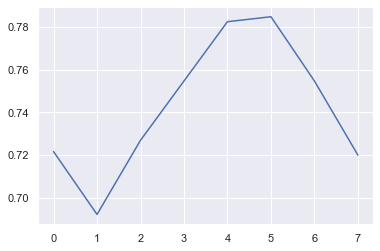

In [208]:
# new_df_lock = pd.DataFrame(columns = ['lock'])
# new_df_conversation = pd.DataFrame(columns = ['conversation'])
# new_df_walk = pd.DataFrame(columns = ['walk'])
# new_df_run = pd.DataFrame(columns = ['run'])
# new_df_sleep = pd.DataFrame(columns = ['sleep'])
# new_df_bt = pd.DataFrame(columns=['frequency'])
# new_df_wifi_location = pd.DataFrame(columns = ['location'])
# df_bt = inputs['bluetooth'][0].set_index('uid')
# new_df_noise = pd.DataFrame(columns=['noise'])
# for uid in df_pos_pre.index:
#     new_df_lock.loc[uid] = df_lock.loc[uid]
#     new_df_conversation.loc[uid] = df_conversation.loc[uid]
#     new_df_sleep.loc[uid] = df_sleep.loc[uid]
#     new_df_bt.loc[uid] = df_bt.loc[uid]
#     new_df_walk.loc[uid] = df_walk.loc[uid]
#     new_df_run.loc[uid] = df_run.loc[uid]
#     new_df_wifi_location.loc[uid] = df_wifi_location.loc[uid]
#     new_df_noise.loc[uid] = df_noise.loc[uid]
#new_df_bt
# X = pd.concat([new_df_bt, new_df_conversation], axis = 1)
#n_neighbour = roc_auc_comparison(X, df_pos_pre)
# df = pd.DataFrame(columns = ['sum'])
#df = df_flour_pre.iloc[:, 4:7].fillna(0).sum(axis=1)
#df = pd.DataFrame(df, columns=['total'])
df =df_flour_pre.iloc[:, 3:4].fillna(0)
df.columns = ['total']

# df
df = binarize(df, 5)
n_neighbour = roc_auc_comparison(X, df)
KNN(X, df, n_neighbour=n_neighbour)

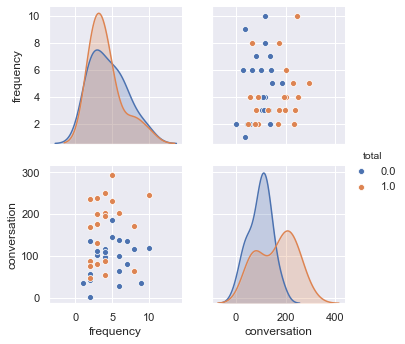

In [209]:
import seaborn as sns

X = X.astype('float')
tempX = pd.concat([X, df], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('total')
sns.pairplot(tempX, hue = 'total', vars = var)
plt.show()

optimal k: 7
accuracy: 0.8


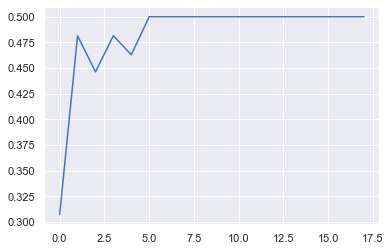

In [622]:
new_df_lock = pd.DataFrame(columns = ['lock'])
new_df_conversation = pd.DataFrame(columns = ['conversation'])
new_df_walk = pd.DataFrame(columns = ['walk'])
new_df_run = pd.DataFrame(columns = ['run'])
new_df_sleep = pd.DataFrame(columns = ['sleep'])
new_df_bt = pd.DataFrame(columns=['frequency'])
new_df_wifi_location = pd.DataFrame(columns = ['location'])
df_bt = inputs['bluetooth'][0].set_index('uid')
new_df_noise = pd.DataFrame(columns=['noise'])
for uid in df_flour_change.index:
    new_df_lock.loc[uid] = df_lock.loc[uid]
    new_df_conversation.loc[uid] = df_conversation.loc[uid]
    new_df_sleep.loc[uid] = df_sleep.loc[uid]
    new_df_bt.loc[uid] = df_bt.loc[uid]
    new_df_walk.loc[uid] = df_walk.loc[uid]
    new_df_run.loc[uid] = df_run.loc[uid]
    new_df_wifi_location.loc[uid] = df_wifi_location.loc[uid]
    new_df_noise.loc[uid] = df_noise.loc[uid]
    
#new_df_bt
X = pd.concat([new_df_sleep, new_df_wifi_location], axis = 1)
n_neighbour = roc_auc_comparison(X, df_flour_change)
#n_neighbour = accuracy_comparison(X, df_total_flour)
KNN(X, df_flour_change, n_neighbour=n_neighbour)

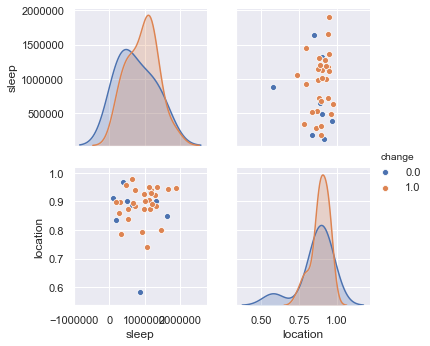

In [623]:
tempX = pd.concat([X, df_flour_change], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('change')
sns.pairplot(tempX, hue = 'change', vars = var)
plt.show()

In [368]:
np.unique(df_total_flour, return_counts = True)
np.unique(df_class, return_counts = True)

(array([1., 3.]), array([22, 15]))

(array([1., 3.]), array([22, 15]))


([<matplotlib.patches.Wedge at 0x15cee37f0>,
 [Text(-0.3221050590501589, 1.0517834049528894, '1.0'),
  Text(0.3221050590501588, -1.0517834049528896, '3.0')])

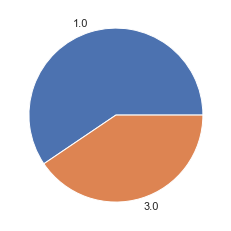

In [369]:
# classes
a = np.unique(df_class, return_counts=True)
print(a)
label = a[0]
y = a[1]
plt.pie(y, labels=label)

In [370]:
# new_df_lock = pd.DataFrame(columns = ['freq'])
# new_df_conversation = pd.DataFrame(columns = ['time'])
# new_df_sleep = pd.DataFrame(columns = ['time'])
# for uid in df_class.index:
#     new_df_lock.loc[uid] = df_lock.loc[uid]
#     new_df_conversation.loc[uid] = df_conversation.loc[uid]
#     new_df_sleep.loc[uid] = df_sleep.loc[uid]
# # n_neighbour = roc_auc_comparison(X, df_class)
# # KNN(X, df_class, n_neighbour)
# X_train, X_test, y_train, y_test = train_test_split(X, df_class.to_numpy().ravel(), random_state=10)
# clf = BernoulliNB()
# clf.fit(X_train,y_train)
# pred = clf.predict(X_test)
# pred = pred.astype(int)
# pred

In [371]:
y_test = y_test.astype(int)
y_test
print(y_test)

print(accuracy_score(y_test, pred))

NameError: name 'y_test' is not defined

In [373]:
#inputs[''][2].head(50)

In [374]:
inputs.keys()

dict_keys(['wifi', 'gps', 'activity', 'phonelock', 'wifi_location', 'audio', 'bluetooth', 'dark', 'phonecharge', 'conversation'])

In [466]:
X = X.astype(dtype = 'float')
## correlation ##
c = X.corr()
c

,conversation,walk
conversation,1.000000,0.546159
walk,0.546159,1.000000


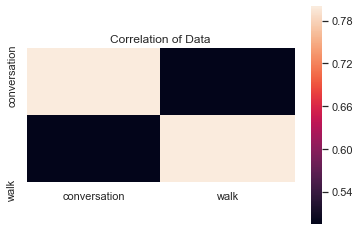

In [456]:
import seaborn as sns
sns.heatmap(c, vmax=.8, square=True)
plt.title("Correlation of Data")
plt.show()

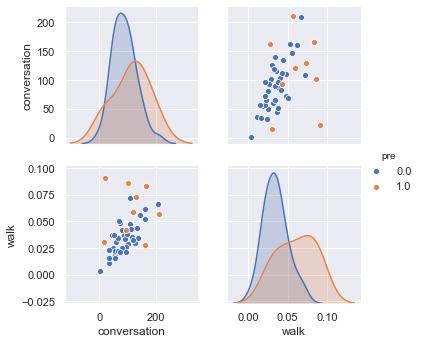

In [457]:
tempX = pd.concat([X, df_pos_pre], axis = 1)
sns.set(color_codes=True)
var = list(tempX.columns)
var.remove('pre')
sns.pairplot(tempX, hue = 'pre', vars = var)
plt.show()

In [145]:
df_flour_pre

,I lead a purposeful and meaningful life,My social relationships are supportive and rewarding,I am engaged and interested in my daily activities,I actively contribute to the happiness and well-being of others,I am competent and capable in the activities that are important to me,I am a good person and live a good life,I am optimistic about my future,People respect me
uid,,,,,,,,
u00,7,6,NaN,6.0,6.0,7.0,7,4
u01,4,6,6.0,6.0,7.0,6.0,4,6
u02,6,7,5.0,6.0,5.0,6.0,4,7
u03,6,2,2.0,4.0,5.0,6.0,5,4
u04,3,5,4.0,3.0,2.0,2.0,3,5
u05,6,6,6.0,6.0,6.0,6.0,6,6
u07,7,5,6.0,5.0,7.0,7.0,7,5
u08,5,5,5.0,5.0,5.0,NaN,4,4
u09,5,4,6.0,6.0,6.0,7.0,7,5


In [146]:
df_pos_pre

,Interested,Strong,Enthusiastic,Proud,Alert,Inspired,Determined,Attentive,Active
uid,,,,,,,,,
u00,5,4,3,3,4,4.0,4,3.0,2
u01,4,2,3,3,4,3.0,4,3.0,4
u02,4,2,3,2,3,2.0,2,3.0,2
u03,4,4,3,1,5,3.0,3,3.0,4
u04,4,3,3,3,3,1.0,3,3.0,4
u05,4,4,4,2,4,3.0,3,4.0,4
u07,3,4,4,5,3,2.0,3,3.0,3
u08,3,3,3,3,3,3.0,5,3.0,4
u09,4,3,3,3,3,2.0,3,3.0,4


In [ ]:
# ### Componenet Analysis on flourishing score ###
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_flour)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_

# ### Componenet Analysis on positive score ###
# df_pos = df_pos.fillna(0)
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_pos)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_

# ### Componenet Analysis on negative score ###
# df_neg = df_neg.fillna(0)
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df_neg)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
# principalDf
# pca.explained_variance_ratio_